# Kaggle Playground S4e1 - Predict Bank Customer Churn
## Links
- Competition: <https://www.kaggle.com/competitions/playground-series-s4e1/overview>
- Dataset used as base of the competition's dataset: <https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction>

## About dataset

The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer. The dataset includes the following attributes:

- Customer ID: A unique identifier for each customer
- Surname: The customer's surname or last name
- Credit Score: A numerical value representing the customer's credit score
- Geography: The country where the customer resides (France, Spain or Germany)
- Gender: The customer's gender (Male or Female)
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank
- Balance: The customer's account balance
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
- EstimatedSalary: The estimated salary of the customer
- Exited: Whether the customer has churned (1 = yes, 0 = no) 

## Load dataset

In [126]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score

In [133]:
df = pd.read_csv(os.path.join('datasets', 'train.csv'))
df_id = df['id']
df.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [93]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


### Exploratory Data Analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


No missing values

In [8]:
y = df['Exited']

In [15]:
type(y.value_counts())

pandas.core.series.Series

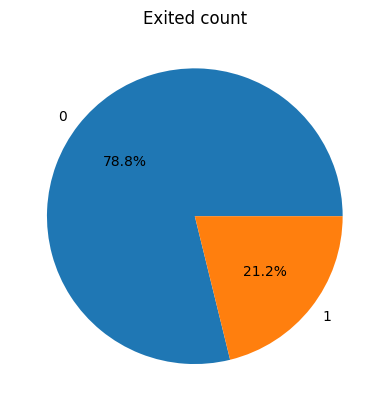

In [21]:
def plot_y(y: pd.Series):
    fig, ax = plt.subplots()
    ax.set_title('Exited count')
    y_value_counts = y.value_counts()
    y_index = y_value_counts.index
    y_values = y_value_counts.values
    ax.pie(y_values, labels=y_index, autopct='%1.1f%%')

plot_y(y)

Need class balacing.

In [94]:
num_variables = df.select_dtypes(['int64', 'float64']).drop(['HasCrCard', 'IsActiveMember'], axis=1)
num_variables

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited
0,668,33.0,3,0.00,2,181449.97,0
1,627,33.0,1,0.00,2,49503.50,0
2,678,40.0,10,0.00,2,184866.69,0
3,581,34.0,2,148882.54,1,84560.88,0
4,716,33.0,5,0.00,2,15068.83,0
...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,1,131834.75,0
165030,792,35.0,3,0.00,1,131834.45,0
165031,565,31.0,5,0.00,1,127429.56,0
165032,554,30.0,7,161533.00,1,71173.03,0


In [74]:
num_variables.groupby('Exited').mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
Exited,,,,,,
0,657.590710,36.560480,5.048796,51255.807752,1.615273,112084.293725
1,652.220469,43.958478,4.914378,71209.978085,1.327854,114402.496656


<Axes: >

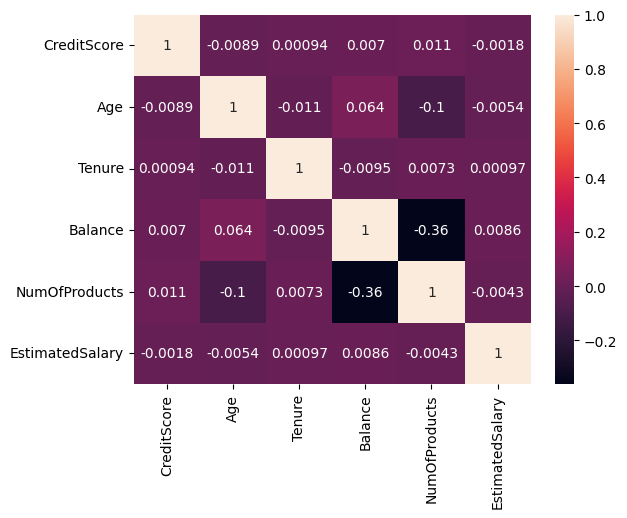

In [26]:
corrmat = num_variables.corr()
sns.heatmap(corrmat, annot=True)

<Axes: xlabel='Balance', ylabel='Age'>

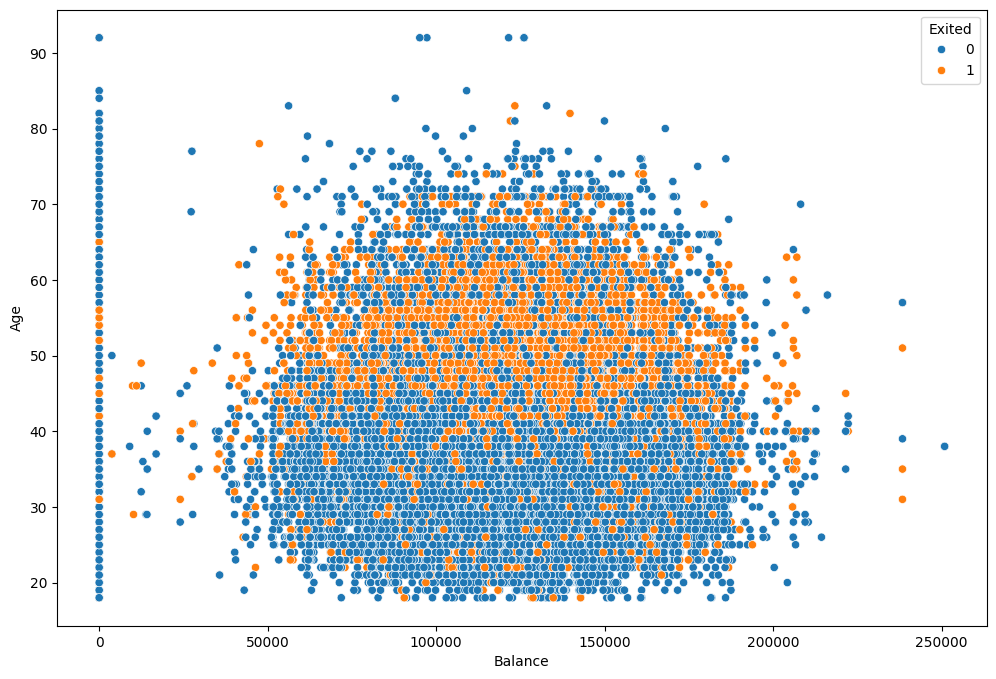

In [78]:
plt.figure(figsize=(12,8))
sns.scatterplot(num_variables, x='Balance', y='Age', hue='Exited')

<Axes: xlabel='Age', ylabel='Count'>

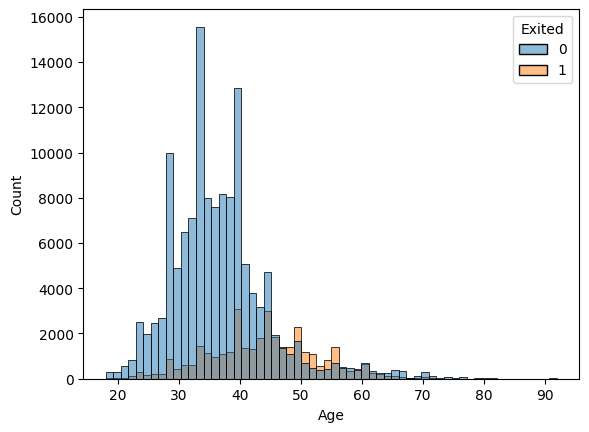

In [82]:
sns.histplot(num_variables, x='Age', hue='Exited', bins=60)

In [155]:
cat_variables = df[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']].astype({'Exited': 'O'})
cat_variables

,Geography,Gender,HasCrCard,IsActiveMember,Exited
0,France,Male,1.0,0.0,0
1,France,Male,1.0,1.0,0
2,France,Male,1.0,0.0,0
3,France,Male,1.0,1.0,0
4,Spain,Male,1.0,1.0,0
...,...,...,...,...,...
165029,Spain,Female,1.0,1.0,0
165030,France,Male,0.0,0.0,0
165031,France,Male,1.0,1.0,0
165032,Spain,Female,0.0,1.0,0


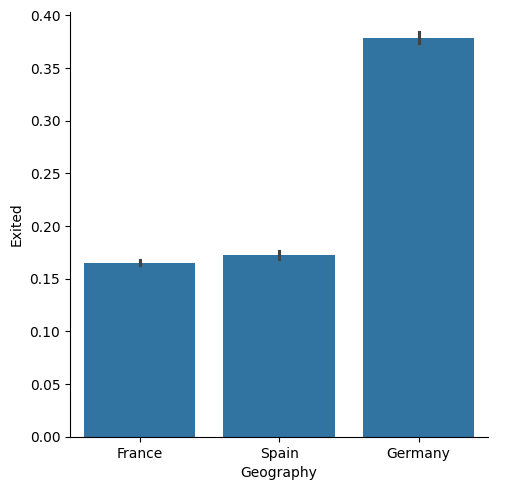

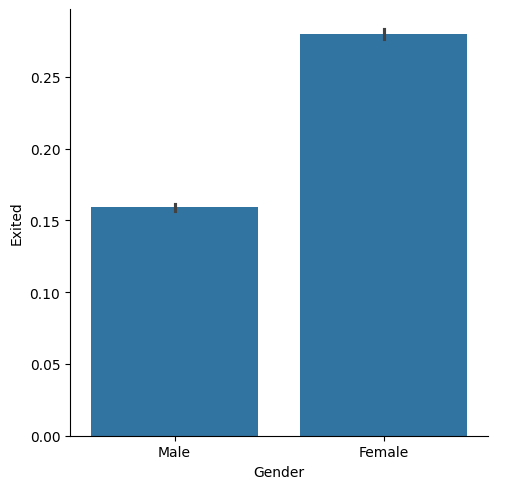

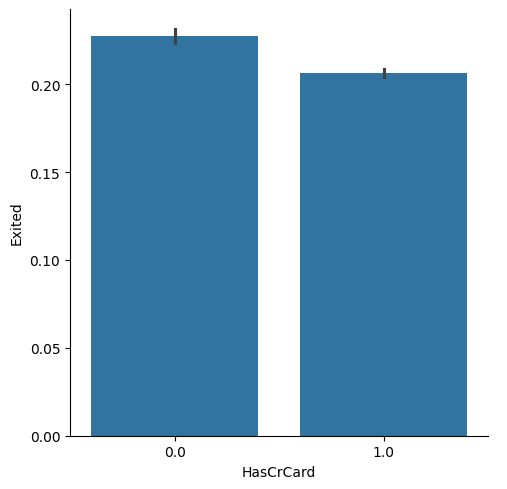

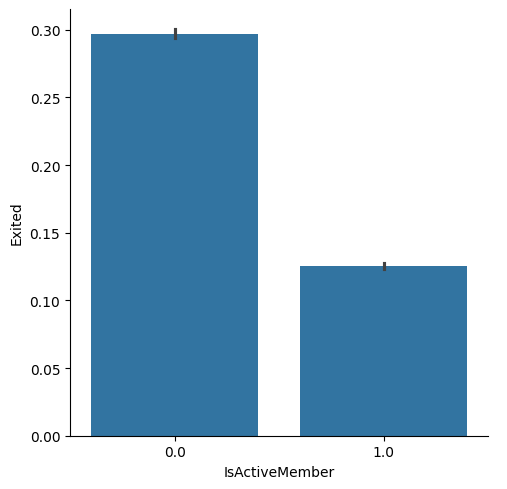

In [156]:
sns.catplot(cat_variables, kind='bar', x='Geography', y='Exited')
sns.catplot(cat_variables, kind='bar', x='Gender', y='Exited')
sns.catplot(cat_variables, kind='bar', x='HasCrCard', y='Exited')
sns.catplot(cat_variables, kind='bar', x='IsActiveMember', y='Exited')

### Models

#### Preprocessing

In [95]:
cat_variables_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_variables_cols = df.select_dtypes(['int64', 'float64']).drop(['HasCrCard', 'IsActiveMember','Exited'], axis=1).columns.to_list()

In [138]:
preprocessor = ColumnTransformer([('num', StandardScaler(), num_variables_cols),
                                   ('cat', OneHotEncoder(), cat_variables_cols)], remainder='drop')

In [197]:
df_trans = preprocessor.set_params(cat__drop='first').fit_transform(df)
df_trans

array([[ 0.14413459, -0.57807434, -0.71997339, ...,  1.        ,
         1.        ,  0.        ],
       [-0.36770579, -0.57807434, -1.43269365, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.2689737 ,  0.21135385,  1.77454751, ...,  1.        ,
         1.        ,  0.        ],
       ...,
       [-1.14170832, -0.80362525, -0.00725313, ...,  1.        ,
         1.        ,  1.        ],
       [-1.27903135, -0.9164007 ,  0.70546712, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.41620652, -0.80362525, -1.43269365, ...,  1.        ,
         1.        ,  0.        ]])

In [198]:
preprocessor.get_feature_names_out()

array(['num__CreditScore', 'num__Age', 'num__Tenure', 'num__Balance',
       'num__NumOfProducts', 'num__EstimatedSalary',
       'cat__Geography_Germany', 'cat__Geography_Spain',
       'cat__Gender_Male', 'cat__HasCrCard_1.0',
       'cat__IsActiveMember_1.0'], dtype=object)

In [199]:
feature_names = num_variables_cols + preprocessor.transformers_[1][1].get_feature_names_out().tolist()

In [200]:
feature_names

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'HasCrCard_1.0',
 'IsActiveMember_1.0']

In [201]:
df_trans.shape

(165034, 11)

#### Logistic Regression

In [141]:
lr_clf = LogisticRegression(random_state=123, class_weight='balanced')

In [202]:
y_pred = cross_val_predict(lr_clf, X=df_trans, y=df['Exited'], cv=5, method='predict_proba')[:,1]
y_pred

array([0.24185885, 0.08685902, 0.3582449 , ..., 0.14214976, 0.24595299,
       0.30389065])

In [143]:
df['Exited']

0         0
1         0
2         0
3         0
4         0
         ..
165029    0
165030    0
165031    0
165032    0
165033    1
Name: Exited, Length: 165034, dtype: int64

In [203]:
roc_auc_score(df['Exited'], y_pred)

0.8187127355106241

In [157]:
lr_clf.fit(X=df_trans, y=df['Exited'])

LogisticRegression(class_weight='balanced', random_state=123)

In [191]:
list(zip(lr_clf.coef_[0,:], feature_names))

[(-0.06181979270574101, 'CreditScore'),
 (0.8706316779925676, 'Age'),
 (-0.04242712171150408, 'Tenure'),
 (-0.035814100475129056, 'Balance'),
 (-0.40309649360385347, 'NumOfProducts'),
 (0.03585374587126583, 'EstimatedSalary'),
 (-0.3947884106606516, 'Geography_France'),
 (0.6758464930918348, 'Geography_Germany'),
 (-0.35236710266267657, 'Geography_Spain'),
 (0.29987969793570357, 'Gender_Male'),
 (-0.3711887181671946, 'HasCrCard_1.0'),
 (0.06766479977219128, 'IsActiveMember_1.0')]

In [204]:
lr_clf.intercept_

array([0.62181737])

### Submission

In [192]:
df_test = pd.read_csv(os.path.join('datasets', 'test.csv'))
df_test_id = df_test['id']
df_test.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)
df_test = preprocessor.set_params(cat__drop='if_binary').fit_transform(df_test)

In [193]:
y_pred = lr_clf.fit(X=df_trans, y=df['Exited']).predict_proba(df_test)[:,1]
y_pred

array([0.08493576, 0.81194929, 0.38613066, ..., 0.18479173, 0.25523305,
       0.61446132])

In [194]:
submission = pd.DataFrame(data={'id': df_test_id, 'Exited': y_pred})
submission.head()

,id,Exited
0,165034,0.084936
1,165035,0.811949
2,165036,0.386131
3,165037,0.437768
4,165038,0.707056


In [195]:
lr_clf.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [196]:
submission.to_csv(os.path.join('submissions','Logistic Regression default - OneHotEncoder drop if binary.csv'), index=False)